The data dat was dropped due to uncertainty of group assignment are tested here on the optimised final model

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from itertools import combinations
import shap
import sys
sys.path.append("../")

import utils_ML as uml

In [2]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

connection succesfull


In [3]:
# Load NSAF data

nsaf = pd.read_hdf("../../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")

data = pd.read_csv("../preprocessing/quantile_norm_NSAF_50.csv", index_col = "assay_id")

meta = pd.read_csv("../../Metadata/unified_metadata.csv", index_col="assay_id")
meta = meta[meta.index.isin(nsaf.index)]

nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [4]:
low_id_rate = nsaf.loc[meta[meta.PXD_accession.isin("PXD002842 PXD003407 PXD003406 PXD002057 PXD009149 PXD005045 PXD009442 PXD003530 PXD004452".split())].index,:].notna().sum(axis=1)
drop_assays = low_id_rate.index[low_id_rate < 1100]
nsaf = nsaf.loc[~nsaf.index.isin(drop_assays)]

meta_filtered = meta[meta.index.isin(nsaf.index)]
print(meta_filtered.PXD_accession.nunique(), "projects and", meta_filtered.shape[0], "proteomes")
meta = meta_filtered.reset_index()
groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")
meta.sort_index(inplace=True)

44 projects and 557 proteomes


In [4]:
meta.Group.unique()

array(['HCC', 'Neuroblastoma', 'SCC', 'HEK293', 'Ductal_breast',
       'Lymphoid_leukemia', 'HUVEC', 'CRC', 'Myeloid_leukemia',
       'glioblastoma', 'Lung', 'PC3', 'OV_endometrioid', 'HeLa', 'iPSC',
       'Skin_cancer', 'DOV13', 'OVCA433', 'OVISE', 'IOSE7576',
       'ovarian_cystadenocarcinoma', 'IOSE397', 'ME180', 'HGSOC',
       'MCF10F', 'RXF-393', 'U251', 'hESC'], dtype=object)

In [5]:
used_columns = data.columns

In [6]:
# Dataset used for all analyses
apc = meta.Group.value_counts(sort = True)
used=apc[apc>=10]
meta_used = meta[meta.Group.isin(used.index)]
nsaf_used = nsaf[nsaf.index.isin(meta_used.index)]
nsaf_used = nsaf_used.loc[:, used_columns]

meta_used.sort_index(inplace=True)
nsaf_used.sort_index(inplace=True)

# Non-used samples
not_used = apc[apc<10]
meta_not_used = meta[meta.Group.isin(not_used.index)]
nsaf_not_used = nsaf[nsaf.index.isin(meta_not_used.index)]
nsaf_not_used = nsaf_not_used.loc[:, used_columns]

meta_not_used.sort_index(inplace=True)
nsaf_not_used.sort_index(inplace=True)

In [7]:
meta_not_used.Group.unique()

array(['Lung', 'PC3', 'Skin_cancer', 'DOV13', 'OVCA433', 'OVISE',
       'IOSE7576', 'IOSE397', 'ME180', 'MCF10F', 'RXF-393', 'U251',
       'hESC'], dtype=object)

In [27]:
meta[meta.PXD_accession=="PXD005940"]

,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id,ionbot_version,Group
assay_id,,,,,,,,,,,,,,,,,,,,
33896,1876,00522_A01_P003811_B0A_A00_R1,657,Colo-205,adenocarcinoma,/,colon,/,NaN,PXD005940,4484,801,262,47,in-gel,LTQ Orbitrap Elite,23933261,61,IONBOT_v0.7.0,CRC
33899,1876,00522_A04_P003812_B0A_A00_R1,660,RXF-393,carcinoma,/,kidney,/,NaN,PXD005940,4331,762,302,41,in-gel,LTQ Orbitrap Elite,23933261,62,IONBOT_v0.7.0,RXF-393
33902,1876,00522_A07_P003813_B0A_A00_R1,567,PC3,carcinoma,/,prostate,/,NaN,PXD005940,1449,258,50,25,in-gel,LTQ Orbitrap Elite,23933261,63,IONBOT_v0.7.0,PC3
33905,1876,00522_A10_P003814_B0A_A00_R1,692,NCI-H460,carcinoma,/,lung,/,NaN,PXD005940,1053,172,82,11,in-gel,LTQ Orbitrap Elite,23933261,64,IONBOT_v0.7.0,Lung
33980,1876,00522_H01_P003811_B0H_A00_R1,659,U251,astrocytoma,/,brain,/,NaN,PXD005940,55612,9356,2626,314,in-gel,LTQ Orbitrap Elite,23933261,65,IONBOT_v0.7.0,U251
33983,1876,00522_H04_P003812_B0H_A00_R1,655,SKOV3,cystadenocarcinoma,/,ovary,/,NaN,PXD005940,57961,10267,4092,323,in-gel,LTQ Orbitrap Elite,23933261,66,IONBOT_v0.7.0,ovarian_cystadenocarcinoma
33986,1876,00522_H07_P003813_B0H_A00_R1,663,M14,melanoma,/,skin,/,NaN,PXD005940,42824,7332,2416,284,in-gel,LTQ Orbitrap Elite,23933261,67,IONBOT_v0.7.0,Skin_cancer
33989,1876,00522_H10_P003814_B0H_A00_R1,551,MCF7,adenocarcinoma,/,breast,/,NaN,PXD005940,40455,6681,2125,304,in-gel,LTQ Orbitrap Elite,23933261,68,IONBOT_v0.7.0,Ductal_breast
34076,1876,00523_H01_P003815_B0H_A00_R1,675,CCRF-CEM,leukemia,/,blood,/,NaN,PXD005940,44111,7581,2386,311,in-gel,LTQ Orbitrap Elite,23933261,69,IONBOT_v0.7.0,Lymphoid_leukemia


In [7]:
meta[meta.cell_line == "PC3"]

,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id,ionbot_version,Group
assay_id,,,,,,,,,,,,,,,,,,,,
31369,1828,20121023_EXQ4_JRW_SA_33L_2,567,PC3,carcinoma,/,prostate,/,NaN,PXD000661,53253,48558,44257,5258,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,PC3
31370,1828,20121023_EXQ4_JRW_SA_33L_3,567,PC3,carcinoma,/,prostate,/,NaN,PXD000661,52008,47584,43387,5232,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,PC3
31371,1828,20121023_EXQ4_JRW_SA_33T_2,567,PC3,carcinoma,/,prostate,/,NaN,PXD000661,41484,36538,32946,5329,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,PC3
33902,1876,00522_A07_P003813_B0A_A00_R1,567,PC3,carcinoma,/,prostate,/,NaN,PXD005940,1449,258,50,25,in-gel,LTQ Orbitrap Elite,23933261,63,IONBOT_v0.7.0,PC3


Quantile normalise as before

In [8]:
ranked_df = nsaf_used.fillna(100).rank(axis=1, method="min").multiply(1/nsaf_used.notna().sum(axis=1), axis="index")
ranked_df = ranked_df.applymap(lambda x: 0 if x>1 else x)

sorted_arrays = []
for i, row in np.log2(nsaf_used).iterrows():
    
    # Sorts the row from smallest to biggest and putting the nans at the back
    row = np.sort(np.array(row))
    sorted_arrays.append(row)
sorted_df = pd.DataFrame(sorted_arrays)

rank_mean = sorted_df.mean().sort_values()
rank_median = sorted_df.median().sort_values()
rank_median = pd.DataFrame(rank_median.dropna(), columns=["Rank_substitution"])
rank_median["index"] = list(range(len(rank_median), 0,-1))
rank_median = rank_median.set_index("index")
rank_mapper = {float(x):rank_median.loc[x].values[0] for x in range(1,len(rank_median)+1)}
rank_median

All-NaN slice encountered


,Rank_substitution
index,
2604,-17.876127
2603,-17.608116
2602,-17.415085
2601,-17.272425
2600,-17.183880
...,...
5,-7.487611
4,-7.464297
3,-7.437607


In [9]:
nsaf_used_ranked = nsaf_used.rank(axis=1, method="average", na_option="keep", ascending=False)
nsaf_not_used_ranked = nsaf_not_used.rank(axis=1, method="average", na_option="keep", ascending=False)

In [10]:
import math
def replace_values(x):
    if np.isnan(x):
        return np.nan
    elif x not in rank_mapper.keys():
        return np.mean([rank_mapper[math.ceil(x)], rank_mapper[math.ceil(x)-1]])
    else:
        return rank_mapper[x]

In [11]:
quant_used = nsaf_used_ranked.applymap(lambda x: replace_values(x))
quant_not_used = nsaf_not_used_ranked.applymap(lambda x: replace_values(x))

quant_used.max(axis=1)

assay_id
30960   -5.565813
30961   -5.565813
31008   -5.565813
31009   -5.565813
31102   -5.565813
           ...   
36558   -5.565813
36563   -5.565813
36568   -5.565813
36573   -5.565813
36578   -5.565813
Length: 518, dtype: float64

Perform feature selection, imputation, minmax, smote and train the model on the used dataset

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

In [13]:
target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta_used.Group)
unique_labels = pd.Series(targets).unique()

In [14]:
with open("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/selected_features.txt", "r") as f:
    features = f.readlines()
    features = [x.strip() for x in features]
quant_used = quant_used.loc[:, features]
quant_not_used = quant_not_used.loc[:, features]

In [15]:
feature_names = quant_used.columns

In [16]:
X_train = quant_used.reset_index(drop=True).rename(columns={quant_used.columns[x]:x for x in range(len(quant_used.columns))})
X_test = quant_not_used.reset_index(drop=True).rename(columns={quant_not_used.columns[x]:x for x in range(len(quant_used.columns))})

In [28]:
imputer = uml.LowestValueImputerGaussian()
imputer.fit(X_train,targets)
X_train = imputer.transform(X_train, targets)
X_test = imputer.transform(X_test)

print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#TODO: imputatievolgorde

# Init
smote = SMOTE()
#vae = vae_utils.VariationalAutoencoder(6, 161, 50)
#vae.load_state_dict(torch.load("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/VAE_model_filtered"))

lr_smote = LogisticRegression(max_iter=10000, C=50, solver="liblinear", penalty="l2")
smote_oversampled, y_oversampled = smote.fit_resample(X_train, targets)
lr_smote.fit(smote_oversampled, y_oversampled)

0
0


LogisticRegression(C=50, max_iter=10000, solver='liblinear')

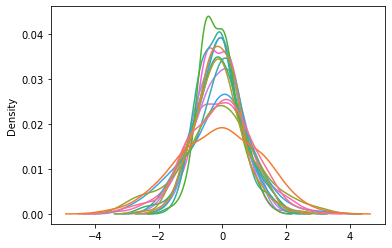

In [18]:
sns.kdeplot(data=pd.DataFrame(lr_smote.coef_).T, legend=False)

In [29]:
y_pred = lr_smote.predict(X_test)

In [30]:
meta_not_used["predictions"] = target_encoder.inverse_transform(y_pred)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(249.0, 0.5, 'True label')

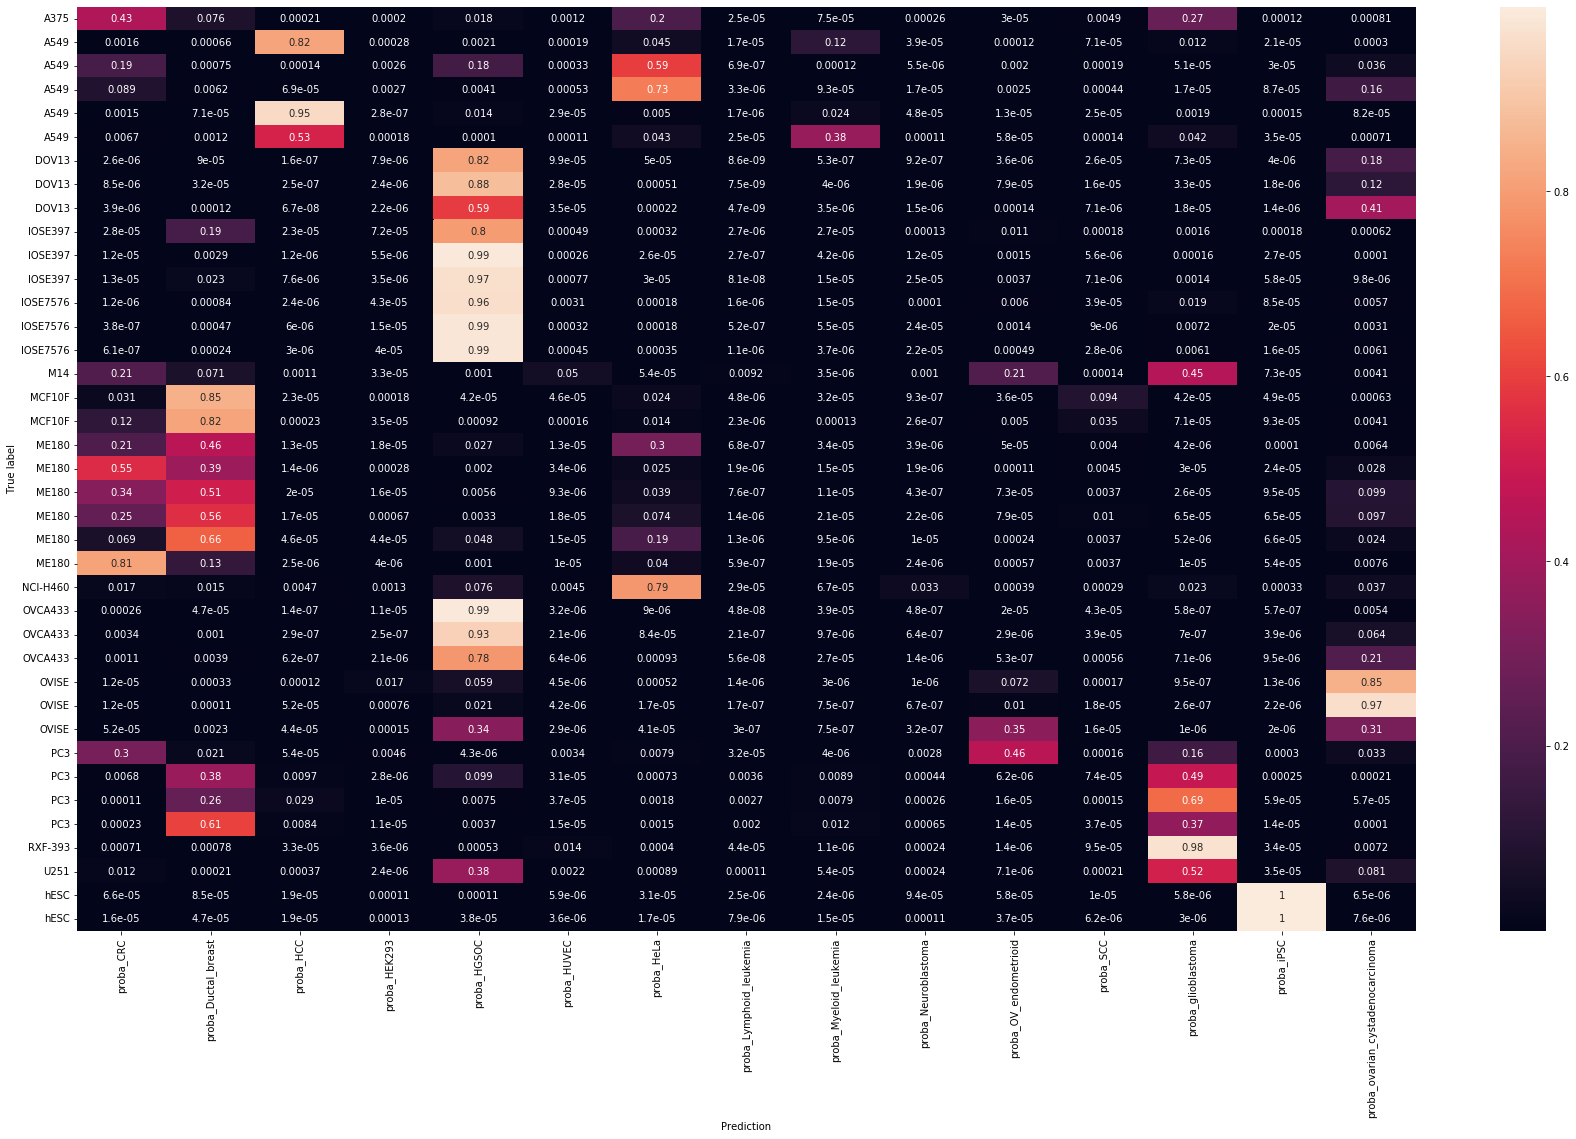

In [20]:
# Feature selection
predictions_lr = pd.DataFrame({'prediction': target_encoder.inverse_transform(y_pred), 'label': meta_not_used.reset_index(drop=True).cell_line})
predictions_lr["correct"] = predictions_lr.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_lr = lr_smote.predict_proba(X_test)
predictions_lr = pd.concat([predictions_lr, pd.DataFrame(proba_predictions_lr, columns = ['proba_'+x for x in target_encoder.inverse_transform(lr_smote.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_lr.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

In [46]:
meta_not_used

,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,...,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id,ionbot_version,Group,predictions
assay_id,,,,,,,,,,,,,,,,,,,,,
31366,1828,20121023_EXQ4_JRW_SA_32L_1,566,A549,adenocarcinoma,/,lung,/,NaN,PXD000661,...,45041,41042,4979,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,Lung,HCC
31367,1828,20121023_EXQ4_JRW_SA_32L_2,566,A549,adenocarcinoma,/,lung,/,NaN,PXD000661,...,44829,40672,4929,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,Lung,HCC
31368,1828,20121023_EXQ4_JRW_SA_32T_3,566,A549,adenocarcinoma,/,lung,/,NaN,PXD000661,...,36048,31822,5033,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,Lung,HCC
31369,1828,20121023_EXQ4_JRW_SA_33L_2,567,PC3,carcinoma,/,prostate,/,NaN,PXD000661,...,48558,44257,5258,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,PC3,glioblastoma
31370,1828,20121023_EXQ4_JRW_SA_33L_3,567,PC3,carcinoma,/,prostate,/,NaN,PXD000661,...,47584,43387,5232,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,PC3,glioblastoma
31371,1828,20121023_EXQ4_JRW_SA_33T_2,567,PC3,carcinoma,/,prostate,/,NaN,PXD000661,...,36538,32946,5329,FASP,Q-exactive,25225357,0,IONBOT_v0.8.0,PC3,Ductal_breast
32359,1864,ath017216,619,A375,melanoma,/,skin,/,NaN,PXD005912,...,7262,2399,839,in-solution,LTQ Orbitrap Velos,30936560,1,IONBOT_v0.7.0,Skin_cancer,CRC
32506,1870,20130312_EXQ4_FaCo_SA_CL_DOV13_A,622,DOV13,adenocarcinoma,/,ovary,/,NaN,PXD003668,...,61771,20500,3267,in-solution,Q-exactive,27561551,0,IONBOT_v0.7.0,DOV13,HGSOC
32507,1870,20130312_EXQ4_FaCo_SA_CL_DOV13_B,622,DOV13,adenocarcinoma,/,ovary,/,NaN,PXD003668,...,61741,20434,3279,in-solution,Q-exactive,27561551,0,IONBOT_v0.7.0,DOV13,HGSOC


Explanations:
- M14: melanoma; Shown to express glial specific markers (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0009712)
- A375: Also melanoma
- RXF-393: Very confidently predicted as glioblastoma; is however renal kidney cell carcinoma
- A549 lung cell carcinomas: predicted as hepatocellular (PXD000661) and as HeLa (PXD004452)
- ME180: cervix cells but classified as breast or colorectal

PXD000661 contained glioblastomas and HCC samples <br>
PXD004452 contained 2 breast, 2 HEK, 2 neuro, 2 CRC and 4 HeLas

In [56]:
meta_used[meta_used.PXD_accession=="PXD003668"].Group.value_counts()

HGSOC                         42
OV_endometrioid               18
ovarian_cystadenocarcinoma     9
Name: Group, dtype: int64

---

Interpreting some predictions

In [32]:
explainer = shap.LinearExplainer(lr_smote, smote_oversampled)

shap_test = explainer.shap_values(X_test)

In [49]:
len(explainer.expected_value)

15

In [52]:
shap.initjs()

In [56]:
shap_test[target_encoder.transform(["glioblastoma"])[0]][meta_not_used.reset_index().cell_line == "PC3"][0].shape

(161,)

In [57]:
shap.force_plot(explainer.expected_value[12], shap_test[target_encoder.transform(["glioblastoma"])[0]][meta_not_used.reset_index().cell_line == "PC3"][0], 
X_test[meta_not_used.reset_index().cell_line == "PC3"][0], feature_names=feature_names)

In [58]:
shap.force_plot(explainer.expected_value[12], shap_test[target_encoder.transform(["glioblastoma"])[0]][meta_not_used.reset_index().cell_line == "PC3"][1], 
X_test[meta_not_used.reset_index().cell_line == "PC3"][1], feature_names=feature_names)

In [59]:
shap.force_plot(explainer.expected_value[12], shap_test[target_encoder.transform(["glioblastoma"])[0]][meta_not_used.reset_index().cell_line == "PC3"][2], 
X_test[meta_not_used.reset_index().cell_line == "PC3"][2], feature_names=feature_names)

In [60]:
shap.force_plot(explainer.expected_value[12], shap_test[target_encoder.transform(["glioblastoma"])[0]][meta_not_used.reset_index().cell_line == "PC3"][3], 
X_test[meta_not_used.reset_index().cell_line == "PC3"][3], feature_names=feature_names)

In [127]:
pd.DataFrame(X_test)[meta_not_used.reset_index().cell_line == "PC3"].mean()

0      0.651693
1      0.658357
2      0.533515
3      0.624386
4      0.420346
         ...   
156    0.632463
157    0.618664
158    0.677931
159    0.645863
160    0.683221
Length: 161, dtype: float64

In [65]:
PC3_feature_imp = pd.DataFrame(shap_test[target_encoder.transform(["glioblastoma"])[0]][meta_not_used.reset_index().cell_line == "PC3"]).T

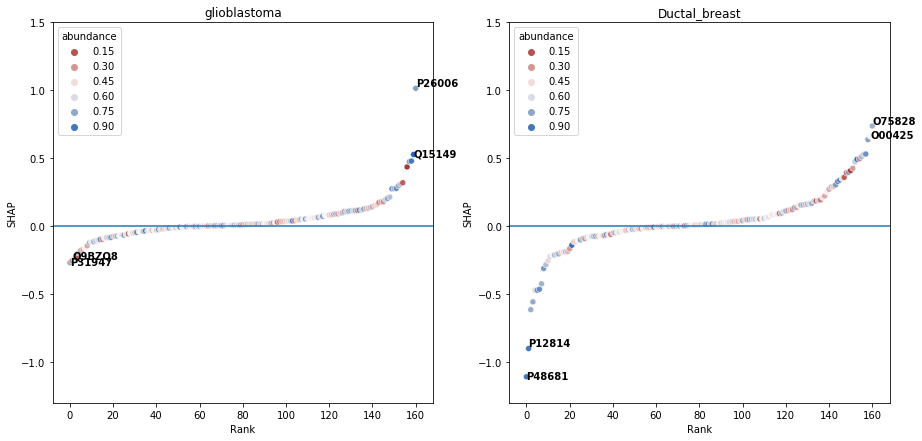

In [133]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
for i, l in enumerate(["glioblastoma", "Ductal_breast"]):

    PC3_feature_imp = pd.DataFrame(shap_test[target_encoder.transform([l])[0]][meta_not_used.reset_index().cell_line == "PC3"]).T
    PC3_feature_imp_mean = PC3_feature_imp.mean(axis=1).reset_index()
    PC3_feature_imp_mean["protein"] = feature_names
    PC3_feature_imp_mean["abundance"] = pd.DataFrame(X_test)[meta_not_used.reset_index().cell_line == "PC3"].mean()
    subset = PC3_feature_imp_mean.sort_values(by=0)

    ax[i].set_ylim((-1.3,1.5))
    ax[i].set_title(l)
    ax[i].axhline(0)
    ax[i].set_ylabel("SHAP")
    ax[i].set_xlabel("Rank")

    flag=True
    for line in range(0,161):
        
        if (subset.iloc[line,1] < subset.iloc[2,1]) or (subset.iloc[line,1] > subset.iloc[158,1]):
            if flag:
                sign = -1
                flag=False
            else:
                flag=True
                sign=1
            ax[i].text(line, subset.iloc[line,1]+.015*sign, subset.protein.iloc[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

    sns.scatterplot(data= subset, y=0, x=list(range(161)), ax=ax[i], hue="abundance", palette='vlag_r')

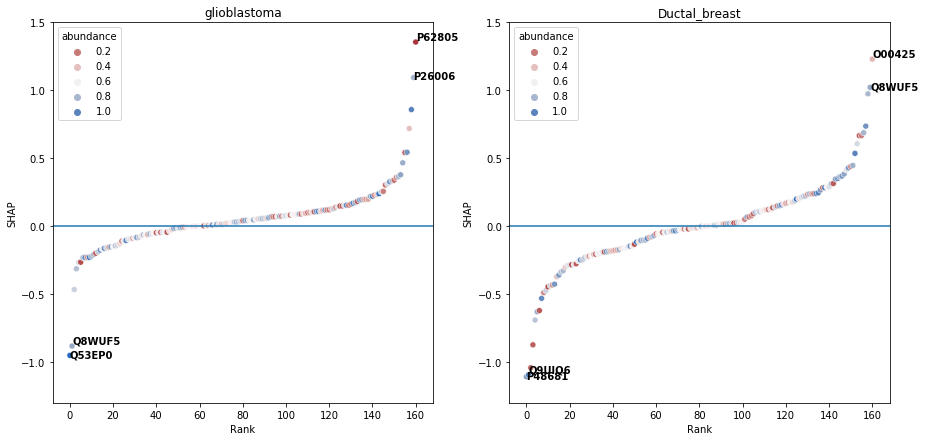

In [137]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
for i, l in enumerate(["glioblastoma", "Ductal_breast"]):

    PC3_feature_imp = pd.DataFrame(shap_test[target_encoder.transform([l])[0]][meta_not_used.reset_index().cell_line == "RXF-393"]).T
    PC3_feature_imp_mean = PC3_feature_imp.mean(axis=1).reset_index()
    PC3_feature_imp_mean["protein"] = feature_names
    PC3_feature_imp_mean["abundance"] = pd.DataFrame(X_test)[meta_not_used.reset_index().cell_line == "RXF-393"].mean()
    subset = PC3_feature_imp_mean.sort_values(by=0)

    ax[i].set_ylim((-1.3,1.5))
    ax[i].set_title(l)
    ax[i].axhline(0)
    ax[i].set_ylabel("SHAP")
    ax[i].set_xlabel("Rank")

    flag=True
    for line in range(0,161):
        
        if (subset.iloc[line,1] < subset.iloc[2,1]) or (subset.iloc[line,1] > subset.iloc[158,1]):
            if flag:
                sign = -1
                flag=False
            else:
                flag=True
                sign=1
            ax[i].text(line, subset.iloc[line,1]+.015*sign, subset.protein.iloc[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

    sns.scatterplot(data= subset, y=0, x=list(range(161)), ax=ax[i], hue="abundance", palette='vlag_r')

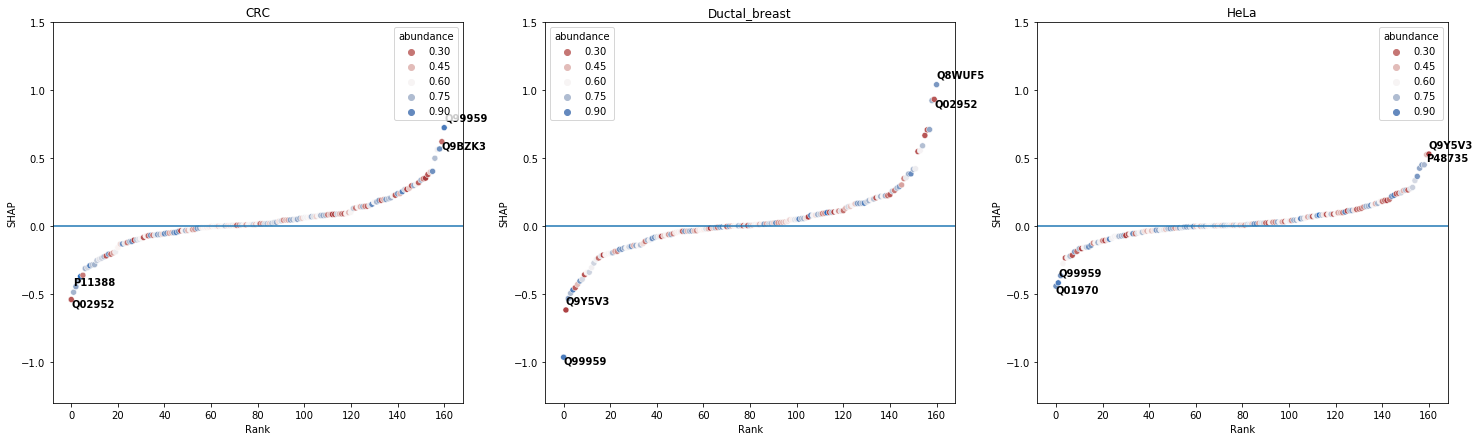

In [141]:
fig, ax = plt.subplots(1,3, figsize=(25,7))
for i, l in enumerate(["CRC", "Ductal_breast", "HeLa"]):

    PC3_feature_imp = pd.DataFrame(shap_test[target_encoder.transform([l])[0]][meta_not_used.reset_index().cell_line == "ME180"]).T
    PC3_feature_imp_mean = PC3_feature_imp.mean(axis=1).reset_index()
    PC3_feature_imp_mean["protein"] = feature_names
    PC3_feature_imp_mean["abundance"] = pd.DataFrame(X_test)[meta_not_used.reset_index().cell_line == "ME180"].mean()
    subset = PC3_feature_imp_mean.sort_values(by=0)

    ax[i].set_ylim((-1.3,1.5))
    ax[i].set_title(l)
    ax[i].axhline(0)
    ax[i].set_ylabel("SHAP")
    ax[i].set_xlabel("Rank")

    flag=True
    for line in range(0,161):
        
        if (subset.iloc[line,1] < subset.iloc[2,1]) or (subset.iloc[line,1] > subset.iloc[158,1]):
            if flag:
                sign = -1
                flag=False
            else:
                flag=True
                sign=1
            ax[i].text(line, subset.iloc[line,1]+.05*sign, subset.protein.iloc[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

    sns.scatterplot(data= subset, y=0, x=list(range(161)), ax=ax[i], hue="abundance", palette='vlag_r')

In [24]:
lr_smote.coef_.shape

(15, 161)

---

Reducing multicollinearity

In [46]:
lr_smote.coef_.shape

(15, 161)

In [34]:
coefs = pd.DataFrame({"coef":lr_smote.coef_[0], "feature": feature_names, "description": uniprot_description.loc[feature_names].description}).sort_values(by="coef")

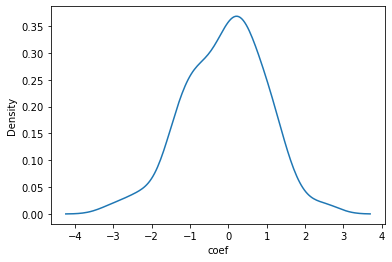

In [68]:
sns.kdeplot(coefs.coef)

In [35]:
coefs[abs(coefs.coef)>2]

,coef,feature,description
P62877,-3.177531,P62877,E3 ubiquitin-protein ligase RBX1
Q14151,-2.994360,Q14151,Scaffold attachment factor B2
Q9BWF3,-2.672951,Q9BWF3,RNA-binding protein 4
Q9BZK3,-2.450601,Q9BZK3,Putative nascent polypeptide-associated comple...
P52594,-2.369545,P52594,Arf-GAP domain and FG repeat-containing protei...
P11388,-2.330259,P11388,DNA topoisomerase 2-alpha
P21266,-2.170838,P21266,Glutathione S-transferase Mu 3
Q8N392,2.151542,Q8N392,Rho GTPase-activating protein 18
Q9UDT6,2.296396,Q9UDT6,CAP-Gly domain-containing linker protein 2
Q92922,2.648779,Q92922,SWI/SNF complex subunit SMARCC1


In [70]:
shaps = explainer.shap_values(smote_oversampled)

In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [82]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif["features"] = feature_names
vif["description"] = uniprot_description.loc[feature_names]

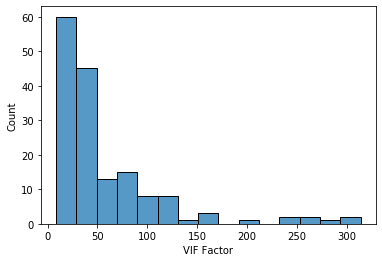

In [84]:
sns.histplot(vif["VIF Factor"])

In [89]:
(vif["VIF Factor"]>50).value_counts()

False    106
True      55
Name: VIF Factor, dtype: int64

In [95]:
X_train[:,0].shape

(518,)

In [111]:
X_train = pd.DataFrame(X_train)
from statsmodels.tools.tools import add_constant

df = add_constant(X_train)

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


In [113]:
iv = df.columns
for i in range(vif.shape[0]):
    
    vif_list = [variance_inflation_factor(df.loc[:,iv], index) for index in range(len(iv))]
    maxvif = max(vif_list)
    print("Max VIF value is ", maxvif)                     
    drop_index = vif_list.index(maxvif)
    print("For Independent variable", feature_names[drop_index])
    
    if maxvif > 10:

        iv = iv.delete(drop_index)


Max VIF value is  3096.3581870242365
For Independent variable A0MZ66
Max VIF value is  314.0567280682328
For Independent variable Q15393
Max VIF value is  293.24119847704605
For Independent variable O75533
Max VIF value is  267.8307609985511
For Independent variable P78417
Max VIF value is  253.96814236642328
For Independent variable P17655
Max VIF value is  235.76289964759343
For Independent variable Q9UIQ6
Max VIF value is  229.0632913828313
For Independent variable O95817
Max VIF value is  215.9177718874962
For Independent variable Q9BW60
Max VIF value is  200.6273576482484
For Independent variable Q9UJC3
Max VIF value is  158.55366087268845
For Independent variable P78527
Max VIF value is  148.58094079550133
For Independent variable P78527
Max VIF value is  138.7379130535839
For Independent variable P11498
Max VIF value is  121.12126216895649
For Independent variable Q08J23
Max VIF value is  117.85450519167077
For Independent variable P31947
Max VIF value is  113.50396730436634
For

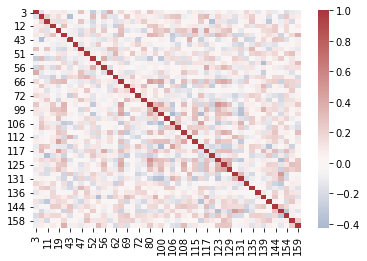

In [107]:
# 47 proteins when reducing collinearity
sns.heatmap(X_train.iloc[:, iv].corr(), cmap="vlag", center=0)

In [104]:
uniprot_description.loc[feature_names[iv]][:]

,description
O00592,Podocalyxin
O00754,Lysosomal alpha-mannosidase
O75828,Carbonyl reductase [NADPH] 3
O75976,Carboxypeptidase D
P07948,Tyrosine-protein kinase Lyn
P19174,"1-phosphatidylinositol 4,5-bisphosphate phosph..."
P20962,Parathymosin
P21266,Glutathione S-transferase Mu 3
P26006,Integrin alpha-3
P29218,Inositol monophosphatase 1
